In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
import time

# <U>Setup the data</U>

In [2]:
#X = [[0], [1], [2], [3]]
#y = [0, 0, 1, 1]
#neigh = KNeighborsClassifier(n_neighbors=3)
#neigh.fit(X, y)
#print(neigh.predict([[1.1]]))

In [3]:
#Load the data
data = pd.read_csv("../data/german_credit_data/german.data", sep=" ", header = None)
data.columns = ['account_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_account_or_bonds',
                'present_employment_since', 'installment_rate', 'personal_status_and_sex', 'other_debtors_or_guarantors',
                'present_residence_since', 'property', 'age', 'other_installment_plans', 'housing', 
                'number_of_exisiting_credits', 'job', 'number_of_people_liable_for_maintenance', 'telephone', 'foreign_worker',
                'class']
data

,account_status,duration,credit_history,purpose,credit_amount,savings_account_or_bonds,present_employment_since,installment_rate,personal_status_and_sex,other_debtors_or_guarantors,...,property,age,other_installment_plans,housing,number_of_exisiting_credits,job,number_of_people_liable_for_maintenance,telephone,foreign_worker,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


In [4]:
#Get a subset of the data
sub_data = data[['credit_amount', 'duration', 'age', 'class']]
sub_data

,credit_amount,duration,age,class
0,1169,6,67,1
1,5951,48,22,2
2,2096,12,49,1
3,7882,42,45,1
4,4870,24,53,2
...,...,...,...,...
995,1736,12,31,1
996,3857,30,40,1
997,804,12,38,1
998,1845,45,23,2


# <U>Part I (Inference Efficiency):<U>

### Compute k-NN Model

In [5]:
def k_NN_model(sub_data, k_NN, is_validation):
    if not is_validation:
        train_data = sub_data.sample(frac = 0.9)
        test_data = sub_data.drop(train_data.index)
    else:
        train_data = sub_data.sample(frac = 0.9)
        remaining_data = sub_data.drop(train_data.index)
        test_data = remaining_data.sample(frac = 0.9)
        validation_data = remaining_data.drop(test_data.index)

    #Apply k-NN model to train_data
    trainY = train_data['class']
    trainX = train_data.drop(['class'], axis=1)
    neigh = KNeighborsClassifier(n_neighbors=k_NN)
    neigh.fit(trainX, trainY)

    if is_validation:
        #Apply k-NN model to validation_data
        validationY = validation_data['class']
        validationX = validation_data.drop(['class'], axis=1)

        start_time = time.time()
        predY = neigh.predict(validationX)
        end_time = time.time()
        predictions = pd.DataFrame(predY, columns = ['Predicted Class'])
        #print(predictions)

        #Compute F-measure, test time
        f_measure =  f1_score(validationY, predY)
        test_time = end_time - start_time;

    else:
        #Apply k-NN model to test_data
        testY = test_data['class']
        testX = test_data.drop(['class'], axis=1)

        start_time = time.time()
        predY = neigh.predict(testX)
        end_time = time.time()
        predictions = pd.DataFrame(predY, columns = ['Predicted Class'])
        #print(predictions)

        #Compute F-measure, test time
        f_measure =  f1_score(testY, predY)
        test_time = end_time - start_time;
    
    return [round(f_measure, 2), round(test_time, 5)]

In [6]:
#Perform k-NN model 5 times
def k_NN_model_x5(sub_data, k_NN, is_validation):
    f_measure_list = ['f_measure']
    test_time_list = ['test_time']

    for x in range(5):
        metrics = k_NN_model(sub_data, k_NN, is_validation)
        #print(metrics)
        f_measure_list.append(metrics[0])
        test_time_list.append(metrics[1])

    avg_f_measure = round(np.mean(f_measure_list[1:]), 2)
    avg_test_time = round(np.mean(test_time_list[1:]), 5)

    f_measure_list.append(avg_f_measure)
    test_time_list.append(avg_test_time)

    #print(f_measure_list)
    #print(test_time_list)

    metrics_data = pd.DataFrame([f_measure_list, test_time_list],
                               columns=['metric', 'trial #1', 'trial #2', 'trial #3', 'trial #4', 'trial #5', 'average'])
    return metrics_data

k_NN_model_x5_results = k_NN_model_x5(sub_data, 5, False)
k_NN_model_x5_results

,metric,trial #1,trial #2,trial #3,trial #4,trial #5,average
0,f_measure,0.81000,0.81000,0.82000,0.80000,0.80000,0.81000
1,test_time,0.00499,0.00499,0.00598,0.00499,0.00499,0.00519


### Compute Decision Tree Classifier (Holdout Method, Gini Index)

In [7]:
#Apply Decision Tree Classifier
def decision_tree_classifier(sub_data, impurity_measure, tree_depth, show_plot=True):
    Y = sub_data['class']
    X = sub_data.drop(['class'], axis=1)

    clf = tree.DecisionTreeClassifier(criterion=impurity_measure, max_depth=tree_depth)
    clf = clf.fit(X, Y)
    
    if show_plot:
        fn=['credit_amount', 'duration', 'age']
        cn=['1', '2']
        fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), dpi=1500)
        tree.plot_tree(clf,
                       feature_names = fn, 
                       class_names=cn,
                       filled = True);
    return clf

In [8]:
clf = decision_tree_classifier(sub_data, 'gini', 4, True)

In [9]:
#Perform holdout
def holdout(sub_data, impurity_measure, tree_depth, is_test):
    #Split data in train and test
    train_data = sub_data.sample(frac = 0.9)
    test_data = sub_data.drop(train_data.index)
    
    #Apply Decision Tree Classifier to train_data
    clf = decision_tree_classifier(train_data, impurity_measure, tree_depth, False)
    
    if (is_test):
        #Apply Decision Tree Classifier to test_data
        testY = test_data['class']
        testX = test_data.drop(['class'],axis=1)

        start_time = time.time()
        predY = clf.predict(testX)
        end_time = time.time()
        predictions = pd.DataFrame(predY, columns = ['Predicted Class'])
        #print(predictions)

        #Compute F-measure, test time
        f_measure =  f1_score(testY, predY)
        test_time = end_time - start_time;

    else:
        #Apply Decision Tree Classifier to train_data
        trainY = train_data['class']
        trainX = train_data.drop(['class'],axis=1)

        start_time = time.time()
        predY = clf.predict(testX)
        end_time = time.time()
        predictions = pd.DataFrame(predY, columns = ['Predicted Class'])
        #print(predictions)

        #Compute F-measure, test time
        f_measure =  f1_score(trainY, predY)
        test_time = end_time - start_time;
    
    return [round(f_measure, 2), round(test_time, 5)]

In [10]:
#Perform holdout 5 times
def holdout_x5(sub_data, impurity_measure, tree_depth, is_test):
    f_measure_list = ['f_measure']
    test_time_list = ['test_time']

    for x in range(5):
        metrics = holdout(sub_data, impurity_measure, tree_depth, is_test)
        #print(metrics)
        f_measure_list.append(metrics[0])
        test_time_list.append(metrics[1])

    avg_f_measure = round(np.mean(f_measure_list[1:]), 2)
    avg_test_time = round(np.mean(test_time_list[1:]), 5)

    f_measure_list.append(avg_f_measure)
    test_time_list.append(avg_test_time)

    #print(f_measure_list)
    #print(test_time_list)

    metrics_data = pd.DataFrame([f_measure_list, test_time_list],
                               columns=['metric', 'trial #1', 'trial #2', 'trial #3', 'trial #4', 'trial #5', 'average'])
    return metrics_data

decision_tree_classifier_x5_results = holdout_x5(sub_data, 'gini', 4, True)
decision_tree_classifier_x5_results

,metric,trial #1,trial #2,trial #3,trial #4,trial #5,average
0,f_measure,0.790,0.880,0.87000,0.760,0.830,0.8300
1,test_time,0.002,0.001,0.00098,0.001,0.001,0.0012


Text(0, 0.5, 'f_measure')

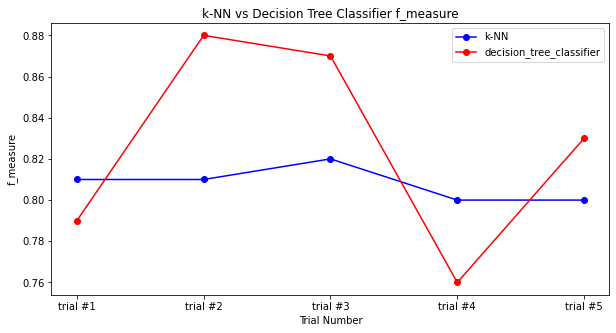

In [11]:
#Plot the f_measure metric
columns = k_NN_model_x5_results.columns.values[1:-1]
f_measure_values_k_NN = k_NN_model_x5_results.loc[0].values[1:-1]
f_measure_values_decision_tree_classifier = decision_tree_classifier_x5_results.loc[0].values[1:-1]


plt.figure(figsize=(10,5))
plt.plot(columns, f_measure_values_k_NN, 'bo-', f_measure_values_decision_tree_classifier, 'ro-')
plt.legend(['k-NN', 'decision_tree_classifier'])
plt.title("k-NN vs Decision Tree Classifier f_measure") 
plt.xlabel('Trial Number')
plt.ylabel('f_measure')

Text(0, 0.5, 'test_time')

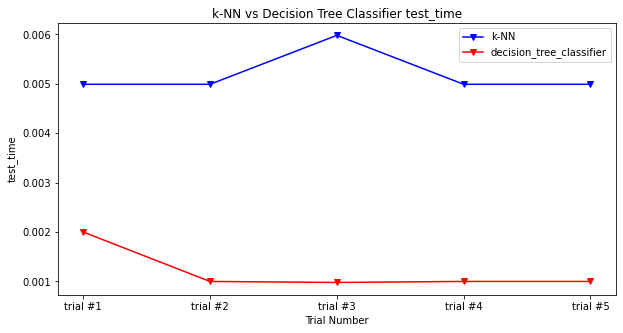

In [12]:
#Plot the test_time metric
columns = k_NN_model_x5_results.columns.values[1:-1]
test_time_values_k_NN = k_NN_model_x5_results.loc[1].values[1:-1]
test_time_values_decision_tree_classifier = decision_tree_classifier_x5_results.loc[1].values[1:-1]


plt.figure(figsize=(10,5))
plt.plot(columns, test_time_values_k_NN, 'bv-', test_time_values_decision_tree_classifier, 'rv-')
plt.legend(['k-NN', 'decision_tree_classifier'])
plt.title("k-NN vs Decision Tree Classifier test_time") 
plt.xlabel('Trial Number')
plt.ylabel('test_time')

# <U>Part II (Model Selection):<U>

In [25]:
#Perform k-NN model with different k(1, 2, 3, 4, 5)
k_list = []
avg_f_measure_list = []
for k_NN in range(1, 6):
    k_NN_model_x5_results = k_NN_model_x5(sub_data, k_NN , True)
    k_list.append(k_NN)
    avg_f_measure_list.append(k_NN_model_x5_results.loc[0]['average'])
k_NN_model_f_measure_data = pd.DataFrame([k_list, avg_f_measure_list]).T
k_NN_model_f_measure_data.columns=['k', 'avg_f_measure']
k_NN_model_f_measure_data

,k,avg_f_measure
0,1.0,0.62
1,2.0,0.73
2,3.0,0.66
3,4.0,0.65
4,5.0,0.83


### Observations:
As it can be seen, based on the results the best k is 4.

In [26]:
#Perform Decision Tree Classifier with different tree depth (3, 4...10) 
tree_depth_list = []
avg_f_measure_list = []
for tree_depth in range(3, 11):
    decision_tree_classifier_x5_results = holdout_x5(sub_data, 'gini', tree_depth, True)
    tree_depth_list.append(tree_depth)
    avg_f_measure_list.append(decision_tree_classifier_x5_results.loc[0]['average'])
decision_tree_model_f_measure_data = pd.DataFrame([tree_depth_list, avg_f_measure_list]).T
decision_tree_model_f_measure_data.columns=['tree_depth', 'avg_f_measure']
decision_tree_model_f_measure_data

,tree_depth,avg_f_measure
0,3.0,0.85
1,4.0,0.82
2,5.0,0.84
3,6.0,0.79
4,7.0,0.81
5,8.0,0.80
6,9.0,0.77
7,10.0,0.76


### Observations:
As it can be seen, based on the results the best tree depth is 3.

Text(0, 0.5, 'f_measure')

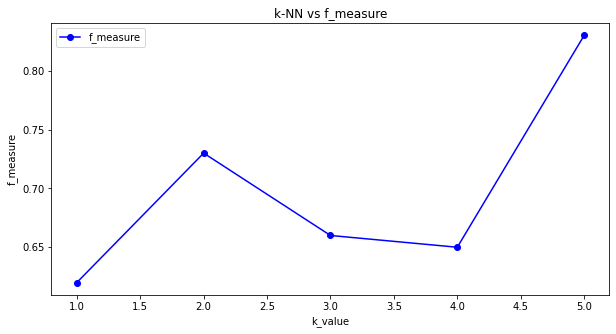

In [31]:
#Plot the k-NN model test
k_NN_values = k_NN_model_f_measure_data['k']
f_measure_values = k_NN_model_f_measure_data['avg_f_measure']
plt.figure(figsize=(10,5))
plt.plot(k_NN_values, f_measure_values, 'bo-')
plt.legend(['f_measure'])
plt.title("k-NN vs f_measure") 
plt.xlabel('k_value')
plt.ylabel('f_measure')

### Observations:
As it can be seen, the f_measure generally increases as the k-value increases.

Text(0, 0.5, 'f_measure')

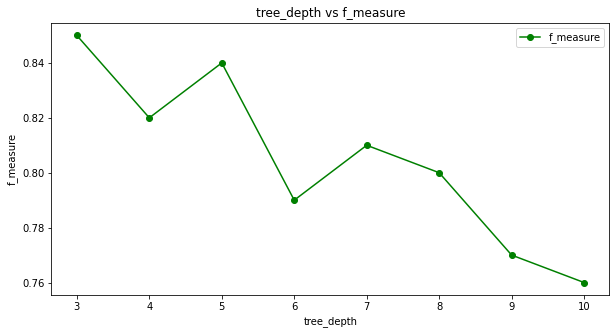

In [32]:
#Plot the decision tree model depth test
depth_values = decision_tree_model_f_measure_data['tree_depth']
f_measure_values = decision_tree_model_f_measure_data['avg_f_measure']
plt.figure(figsize=(10,5))
plt.plot(depth_values, f_measure_values, 'go-')
plt.legend(['f_measure'])
plt.title("tree_depth vs f_measure") 
plt.xlabel('tree_depth')
plt.ylabel('f_measure')

### Observations:
As it can be seen, the f_measure generally decreases as the tree depth increases.